In [86]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report

PATH_PROJECT = "/home/yoshraf/projects/mestrado/"

# Reading data
X_train = pd.read_parquet(f"{PATH_PROJECT}data/discrete_choice/X_train.parquet")
X_test = pd.read_parquet(f"{PATH_PROJECT}data/discrete_choice/X_test.parquet")
y_train = pd.read_parquet(f"{PATH_PROJECT}data/discrete_choice/y_train.parquet")
y_test = pd.read_parquet(f"{PATH_PROJECT}data/discrete_choice/y_test.parquet")

# Show all columns
pd.set_option('display.max_columns', None)

### Descovering

In [2]:
X_train.head()

,,,,,Idade,Total de viagens da pessoa,Hora Saída,loc_origem_count_parada,loc_origem_count_ilum_std,loc_origem_dist_metro,loc_origem_dist_trem,loc_origem_dist_term,loc_origem_dist_ciclo,loc_origem_ACC_TI_A_E_60M,loc_origem_ACC_TI_A_L_TP_,loc_destino_count_parada,loc_destino_count_ilum_std,loc_destino_dist_metro,loc_destino_dist_trem,loc_destino_dist_term,loc_destino_dist_ciclo,loc_destino_ACC_TI_A_E_60M,loc_destino_ACC_TI_A_L_TP_,per Quantidade de automóveis,per Quantidade de motocicletas,per Quantidade de bicicletas,per Renda familiar mensal,dist_od,diff_cota_od,Gênero_Masculino
Identifica pessoa,Zona de domicílio,Data da entrevista,Coordenada X domicílio,Coordenada Y domicílio,,,,,,,,,,,,,,,,,,,,,,,,,,
00282196101,28.0,23092018,331708.0,7393299.0,57.0,2.0,14.333333,1,105,1217.800987,3547.932804,3290.091381,262.058333,4271617.0,416.0,1,105,522.681713,3338.014663,1731.309643,407.683457,4428729.0,390.0,0.000000,0.000000,0.000000,695.330805,1560.489987,-24.773333,1.0
03200074102,320.0,16042018,324560.0,7387434.0,50.0,2.0,15.000000,6,98,2610.339533,1097.721910,3911.528738,870.573780,3808520.0,66.0,6,98,3145.783687,1676.729890,3548.631386,123.953564,3433596.0,50.0,0.333333,0.000000,0.000000,1259.396241,989.388700,-28.240000,0.0
01390799104,139.0,07092018,328546.0,7400276.0,22.0,3.0,18.000000,10,113,5503.727391,825.719028,3485.088204,1709.453065,4133904.0,14.0,10,113,2559.764059,635.834474,1182.175734,1144.271832,4186343.0,100.0,0.250000,0.000000,0.250000,1454.919190,4537.895988,-1.226667,1.0
01450014103,145.0,13092018,331661.0,7405242.0,3.0,3.0,16.166667,18,102,3638.680105,7013.471551,3091.080886,1541.727299,2744403.0,28.0,18,102,5278.306987,8075.650228,3071.512881,3041.387345,2046003.0,11.0,0.250000,0.250000,0.250000,1535.644803,1652.538653,-19.756667,0.0
01101363101,110.0,30082018,324281.0,7400397.0,56.0,6.0,8.500000,91,270,6241.442818,885.358367,1345.022495,1465.401416,3800721.0,20.0,91,270,7283.449171,37.424197,274.774199,1595.063710,2559290.0,18.0,0.320114,0.036663,0.192165,1020.879954,1088.601396,-2.990000,1.0


In [3]:
X_train.shape

(76598, 26)

In [4]:
y_train["Modo Principal"].value_counts(normalize=True)

A pé                                                   0.302893
Dirigindo automóvel                                    0.242278
Ônibus/micro-ônibus/perua do município de São Paulo    0.164704
Metrô                                                  0.109494
Passageiro de automóvel                                0.082587
Transporte escolar                                     0.033617
Táxi não convencional                                  0.018525
Dirigindo moto                                         0.016867
Trem                                                   0.012611
Bicicleta                                              0.008616
Táxi convencional                                      0.007807
Name: Modo Principal, dtype: float64

### Machine Learning Model

In [84]:
def rf_modeling(X_train, X_test, y_train, y_test, params):
    # Fit and Training model
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    # Predict test and train datasets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # Plot Confusion Matrix
    fig, ax = plt.subplots(1, figsize=(12,6))
    plot_confusion_matrix(model, X_test, y_test, ax=ax)
    labels = ["A Pé", "Carro", "Bus", "Uber", "Bike", "Moto", "Metro/Trem"]
    # Classification Report
    print(classification_report(y_test, y_pred_test, target_names=labels))
    print("Main Features:")
    feats = {}
    for feature, importance in zip(X_train.columns, model.feature_importances_):
        feats[feature] = importance * 100
    df_imp = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'}).sort_values("Importance", ascending=False)
    print(df_imp.head(10))
    return model

def logit_modeling(X_train, X_test, y_train, y_test, params):
    # Fit and Training model
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)
    # Predict test and train datasets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # Plot Confusion Matrix
    fig, ax = plt.subplots(1, figsize=(12,6))
    plot_confusion_matrix(model, X_test, y_test, ax=ax)
    labels = ["A Pé", "Carro", "Bus", "Uber", "Bike", "Moto", "Metro/Trem"]
    # Classification Report
    print(classification_report(y_test, y_pred_test, target_names=labels))
    return model

In [68]:
map_dict ={
    "Passageiro de automóvel": 1,
    "Dirigindo automóvel": 1,
    "Ônibus/micro-ônibus/perua do município de São Paulo": 2,
    "Táxi não convencional": 3,
    "Táxi convencional": 3,
    "Bicicleta": 4,
    "Dirigindo moto": 5,
    "Metrô":6,
    "Trem": 6
}

map_ref ={
        0: "A pé",
        1: "Carro",
        2: "Ônibus",
        3: "Uber",
        4: "Bike",
        5: "Moto",
        6: "Metro/trem"
    }

y_train_new = y_train["Modo Principal"].map(map_dict).fillna(0)
y_test_new = y_test["Modo Principal"].map(map_dict).fillna(0)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

        A Pé       0.82      0.89      0.85     10996
       Carro       0.65      0.82      0.72     10710
         Bus       0.60      0.46      0.52      5443
        Uber       0.00      0.00      0.00       876
        Bike       0.00      0.00      0.00       288
        Moto       0.00      0.00      0.00       553
  Metro/Trem       0.63      0.52      0.57      3963

    accuracy                           0.70     32829
   macro avg       0.39      0.38      0.38     32829
weighted avg       0.66      0.70      0.68     32829

Main Features:
                              Importance
dist_od                        44.428973
per Quantidade de automóveis   14.767865
Idade                           7.246477
per Renda familiar mensal       5.609843
Total de viagens da pessoa      3.319791
diff_cota_od                    2.785996
loc_origem_dist_metro           2.137126
loc_destino_dist_metro          2.136025
loc_destino_ACC_TI_

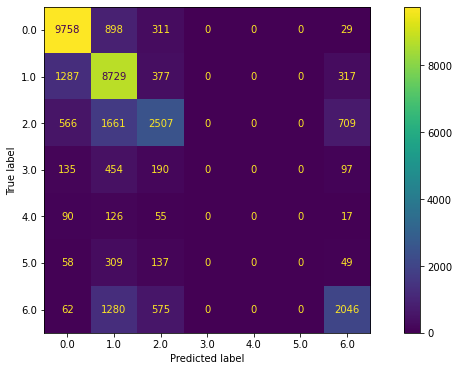

In [89]:
clf_params = {"n_estimators": 1000, "max_depth": 12, "random_state": 0, "min_samples_leaf": 30, "max_features": "auto", "max_samples": .8, "n_jobs": -1}
clf_rf = rf_modeling(X_train, X_test, y_train_new, y_test_new, clf_params)
# clf_rf = rf_modeling(X_train, X_test, y_train_new, y_test_new, {})

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

        A Pé       0.67      0.92      0.78     10996
       Carro       0.48      0.61      0.54     10710
         Bus       0.48      0.09      0.15      5443
        Uber       0.00      0.00      0.00       876
        Bike       0.00      0.00      0.00       288
        Moto       0.00      0.00      0.00       553
  Metro/Trem       0.52      0.38      0.44      3963

    accuracy                           0.57     32829
   macro avg       0.31      0.29      0.27     32829
weighted avg       0.52      0.57      0.51     32829



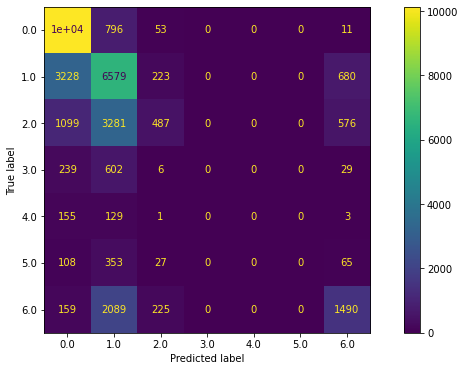

In [87]:
clf_rf = logit_modeling(X_train, X_test, y_train_new, y_test_new, {"max_iter": 1000})

In [8]:
sample = X_train.sample(1000)
explainer = shap.Explainer(clf_rf)
shap_values = explainer(sample)

In [10]:
# Expected Values
shap_values.base_values[0]

array([0.33633604, 0.32510656, 0.16447371, 0.02639381, 0.00856784,
       0.01693332, 0.12218871])

# SHAP Feature Importance

In [11]:
sum_all = shap_values[:,:,1]+shap_values[:,:,2]+shap_values[:,:,3]+shap_values[:,:,4]+shap_values[:,:,5]+shap_values[:,:,6]+shap_values[:,:,1]+shap_values[:,:,0]

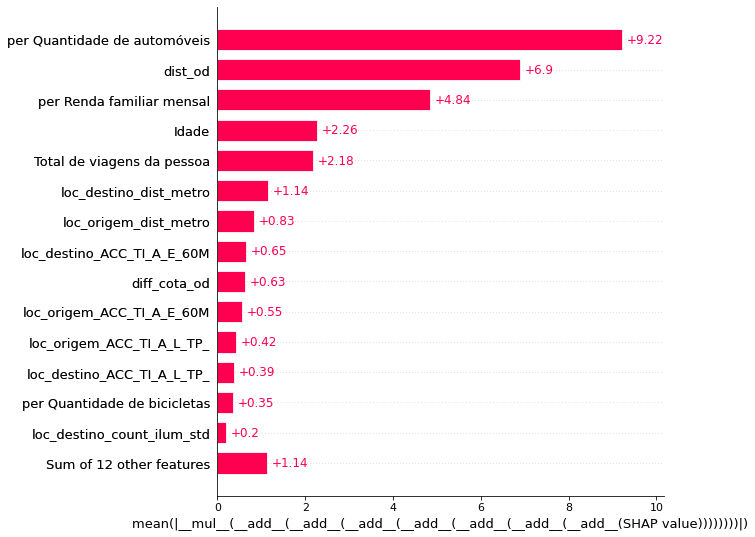

In [12]:
shap.plots.bar(sum_all*100, max_display=15)

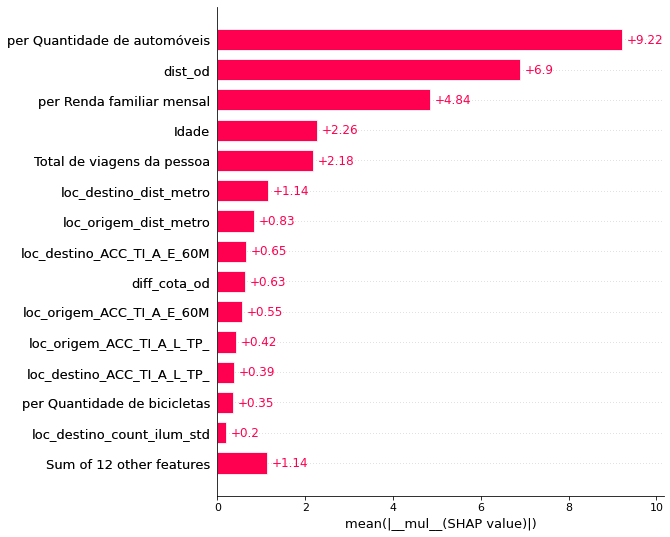

In [21]:
shap.plots.bar(shap_values[:,:,1]*100, max_display=15)

#### Max SHAP Value

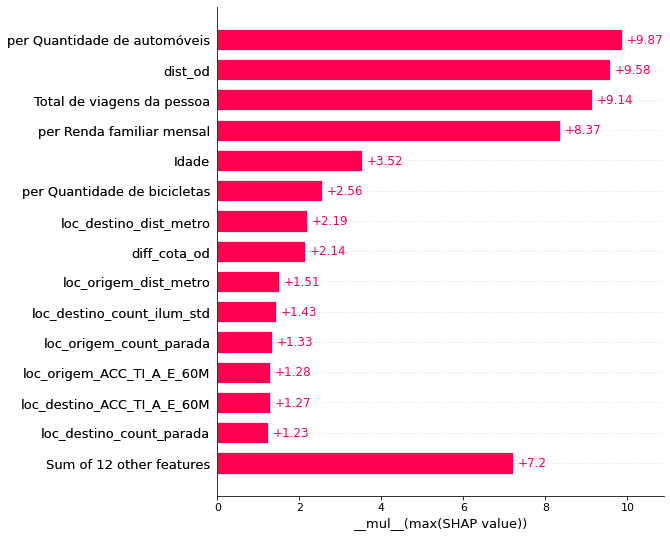

In [22]:
shap.plots.bar(shap_values[:,:,1].max(0)*100, max_display=15, order=shap_values[:,:,1].max(0)*100)

#### Min SHAP Value

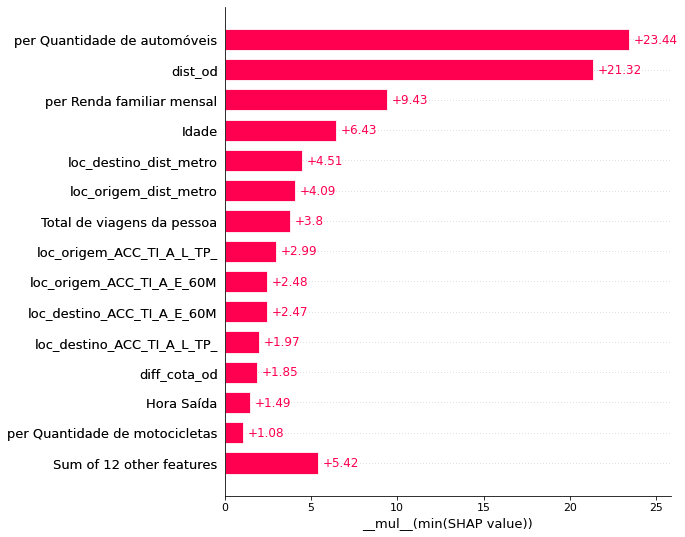

In [20]:
shap.plots.bar(shap_values[:,:,1].min(0)*-100, max_display=15, order=shap_values[:,:,1].min(0)*-100)

### Beeswarm Summarize Plot

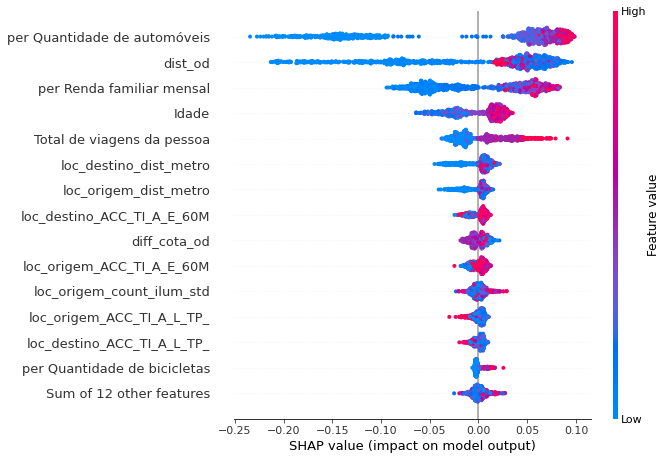

In [23]:
shap.plots.beeswarm(sum_all, max_display=15)

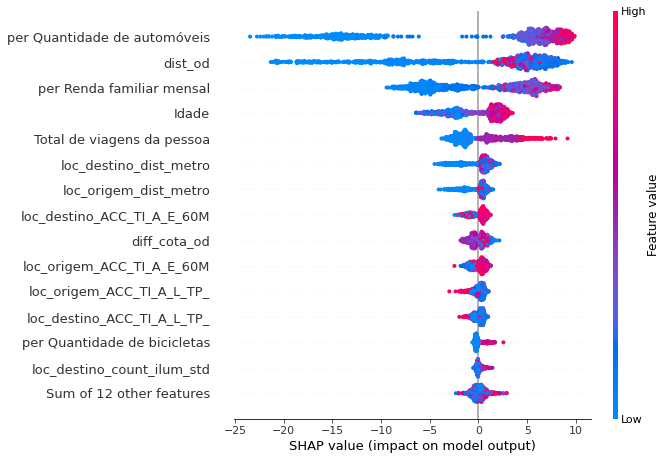

In [24]:
shap.plots.beeswarm(shap_values[:,:,1]*100, max_display=15)

### Understanding Main Features
#### SHAP PDP

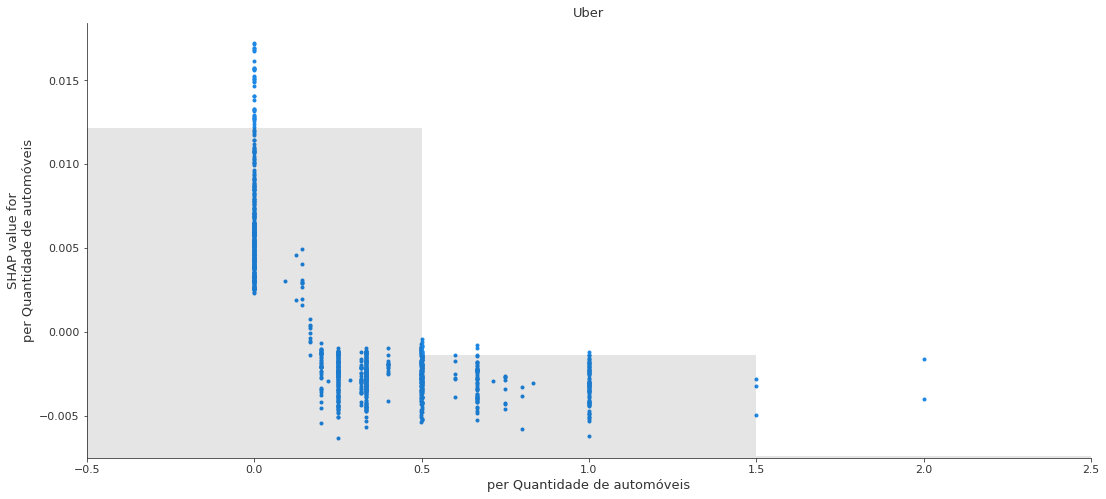

In [70]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 3
shap.plots.scatter(shap_values[:,"per Quantidade de automóveis",modo], ax=ax, title=map_ref[modo])

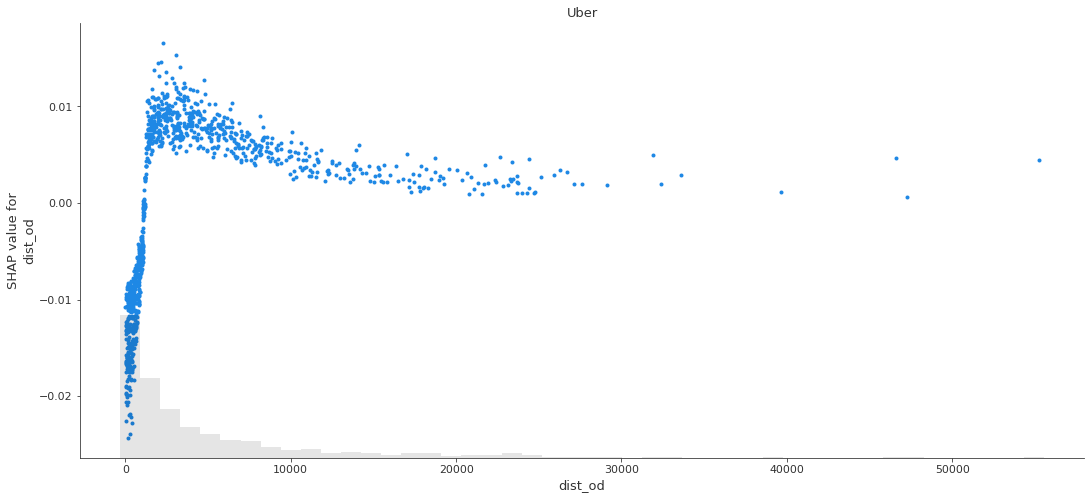

In [71]:
fig, ax = plt.subplots(1, figsize=(18,8))
shap.plots.scatter(shap_values[:,"dist_od",3], ax=ax,  title=map_ref[modo])

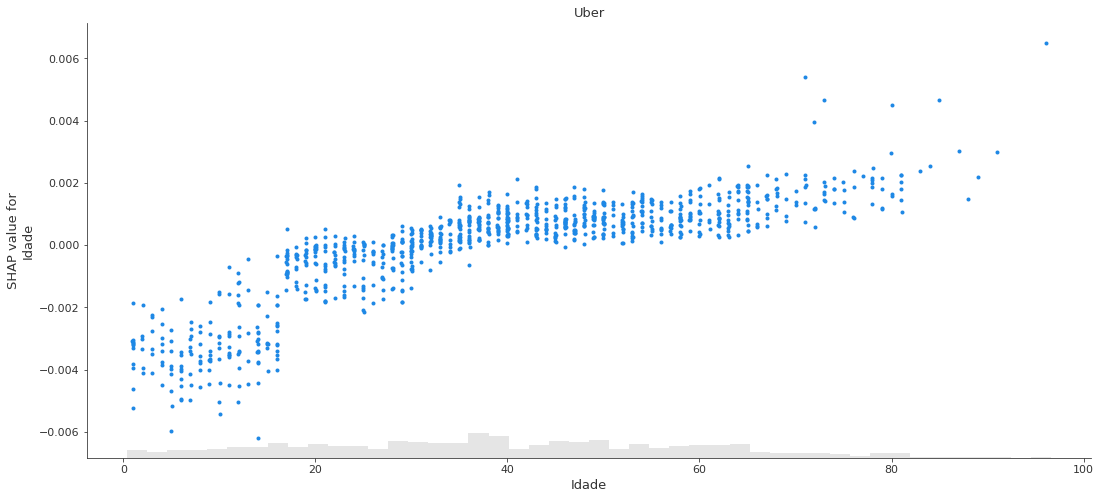

In [72]:
fig, ax = plt.subplots(1, figsize=(18,8))
shap.plots.scatter(shap_values[:,"Idade",3], ax=ax,  title=map_ref[modo])

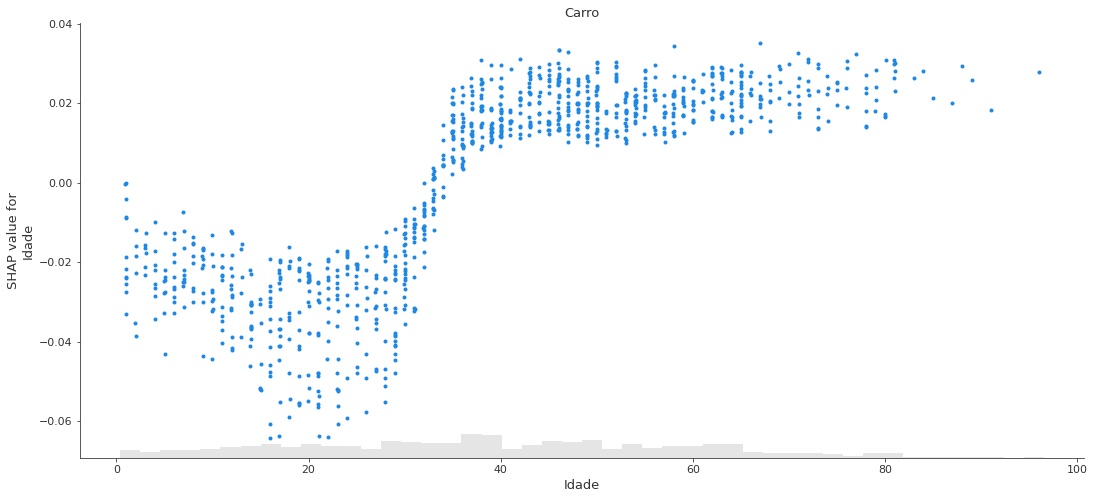

In [73]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 1
shap.plots.scatter(shap_values[:,"Idade",modo], ax=ax,  title=map_ref[modo])

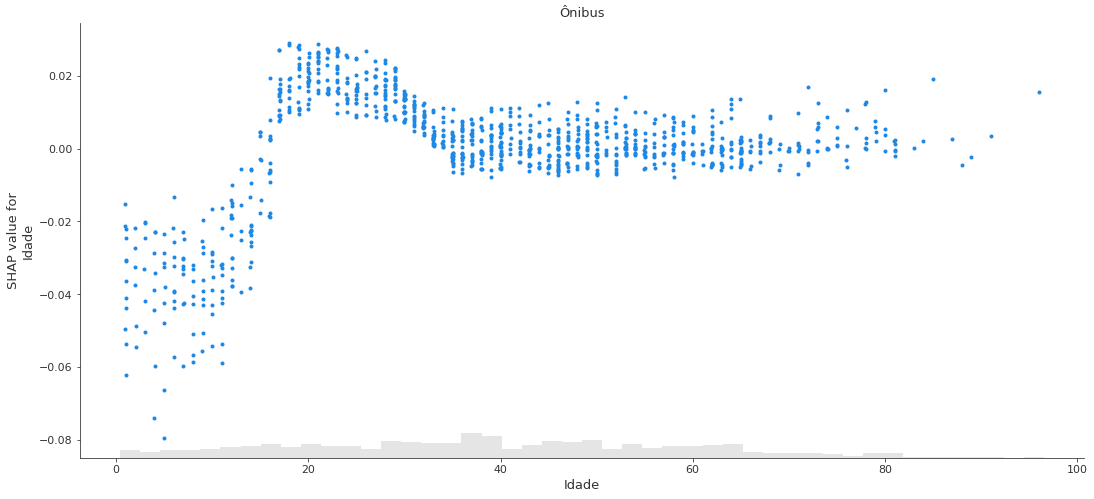

In [74]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 2
shap.plots.scatter(shap_values[:,"Idade",modo], ax=ax,  title=map_ref[modo])

#### Plot for 2 Features

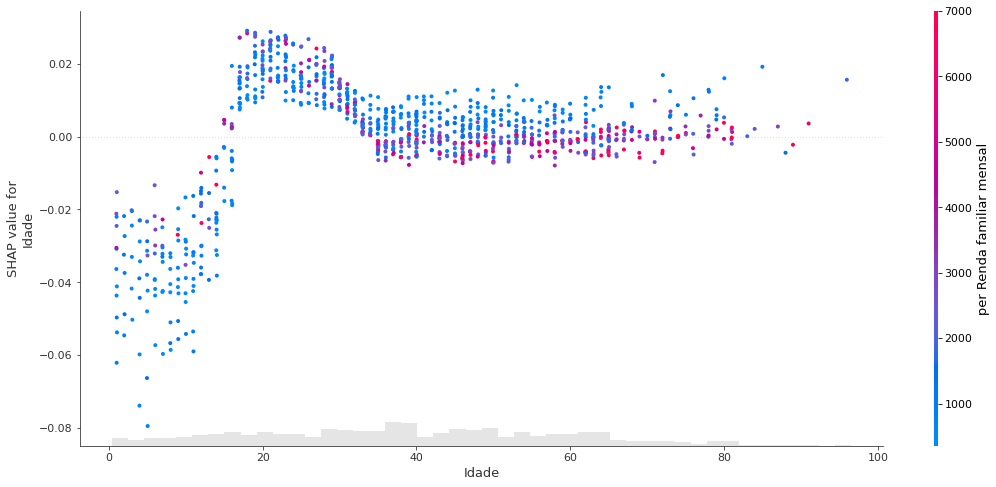

In [60]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 2
shap.plots.scatter(shap_values[:,"Idade",modo], color=shap_values[:,"per Renda familiar mensal",2], ax=ax,  title=map_ref[modo])

#### Categorical Data

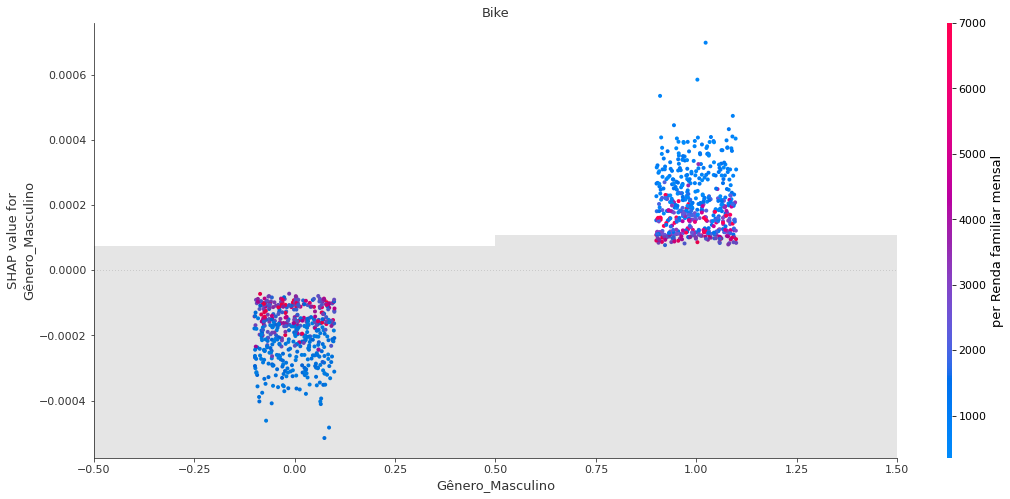

In [77]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 4
shap.plots.scatter(shap_values[:,"Gênero_Masculino",modo], color=shap_values[:,"per Renda familiar mensal",modo],  title=map_ref[modo], ax=ax)

### SHAP ICE and PDP

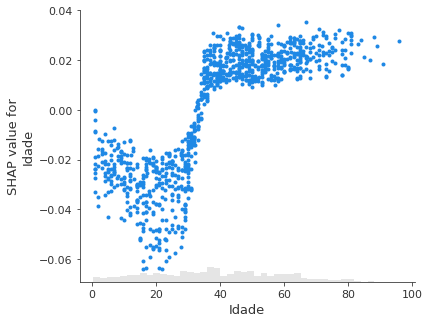

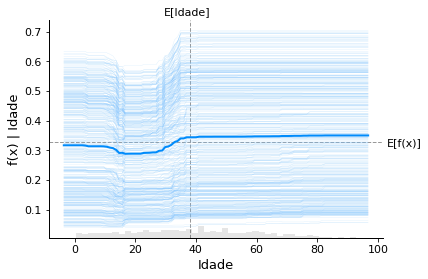

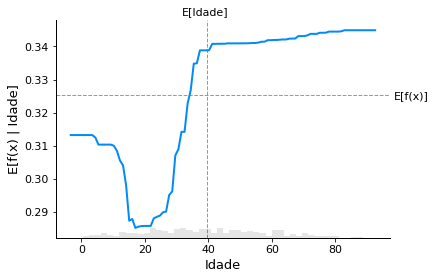

In [63]:
def predict_to_dp(x):
    return clf_rf.predict_proba(x)[:,1]

shap.plots.scatter(shap_values[:,"Idade",1])

shap.partial_dependence_plot(
    "Idade", predict_to_dp, X_train.sample(500), model_expected_value=True,
    feature_expected_value=True, ice=True
)

shap.partial_dependence_plot(
    "Idade", predict_to_dp, X_train.sample(500), model_expected_value=True,
    feature_expected_value=True, ice=False
)

### Correlation Matrix

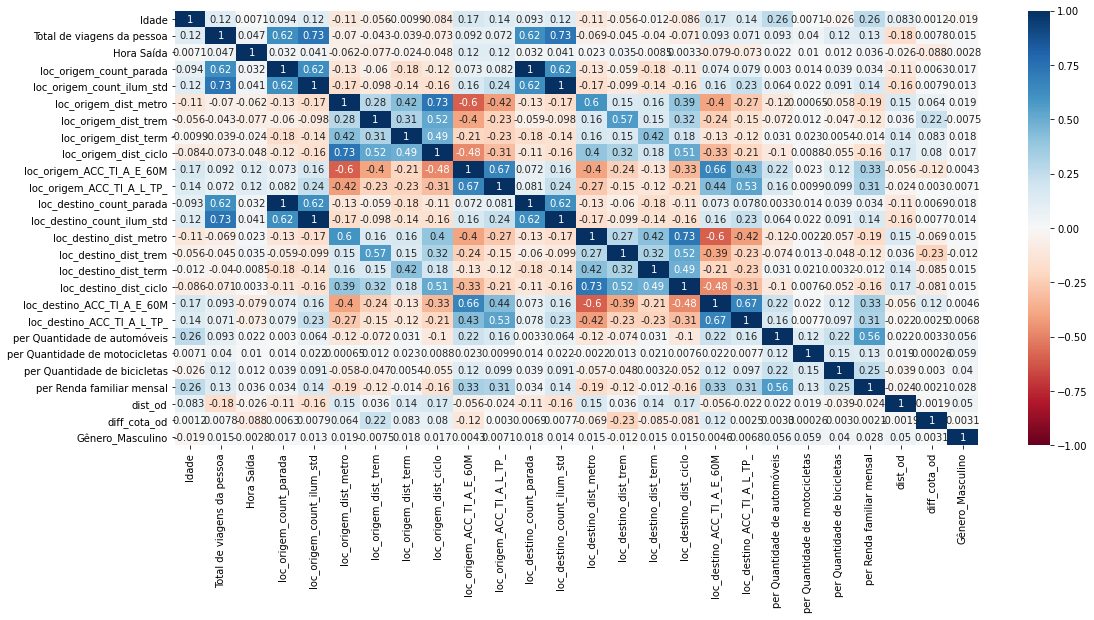

In [43]:
fig, ax = plt.subplots(1, figsize=(18,8))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True, cmap='RdBu', ax=ax)

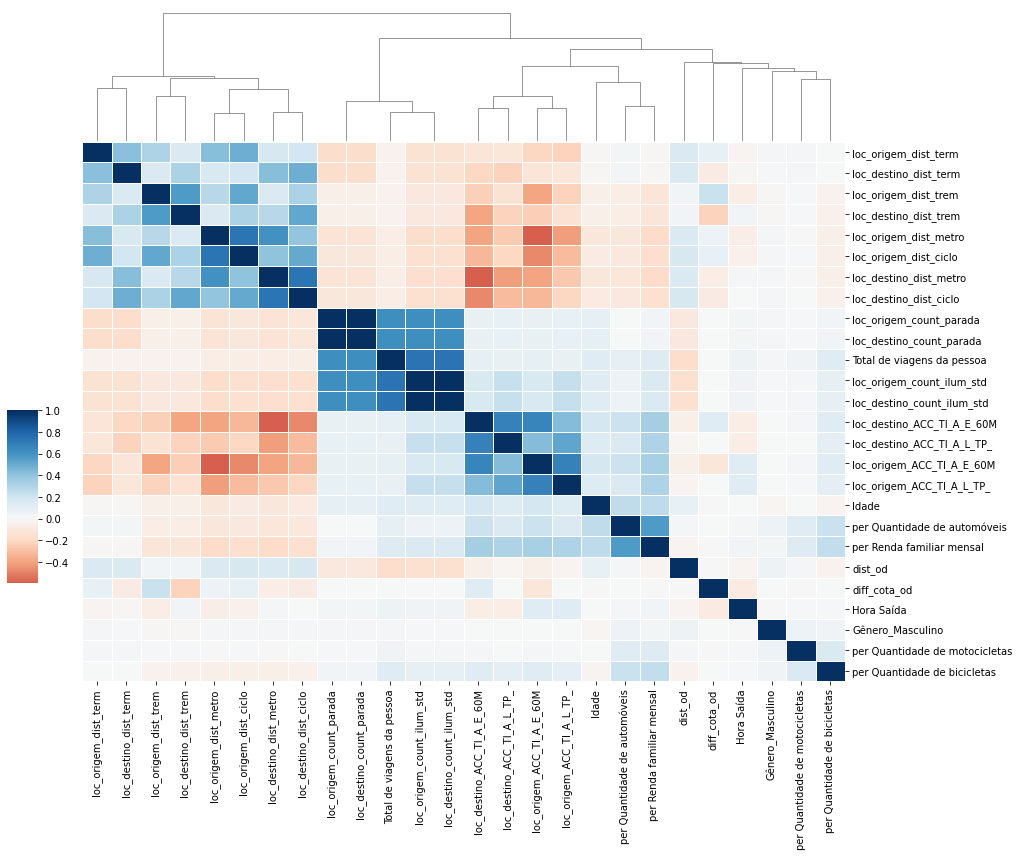

In [44]:
f = .8
g = sns.clustermap(X_train.corr(), center=0, cmap="RdBu",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(18*f, 15*f))
g.ax_row_dendrogram.remove()

### SHAP Correlation Matrix | Feature Behavior Correlation

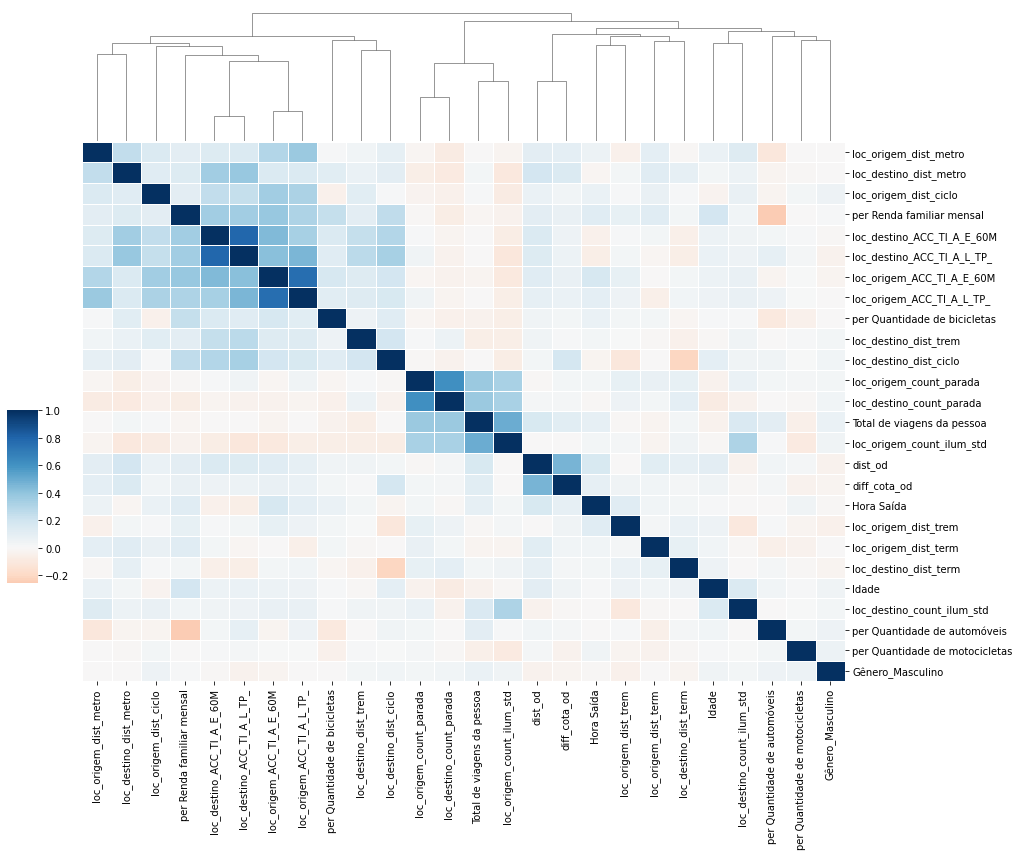

In [45]:
df_shap = pd.DataFrame(shap_values.values[:,:,3], columns=shap_values.feature_names)

f = .8
# Draw the full plot
g = sns.clustermap(df_shap.corr(), center=0, cmap="RdBu",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(18*f, 15*f))
g.ax_row_dendrogram.remove()

### SHAP Clustering

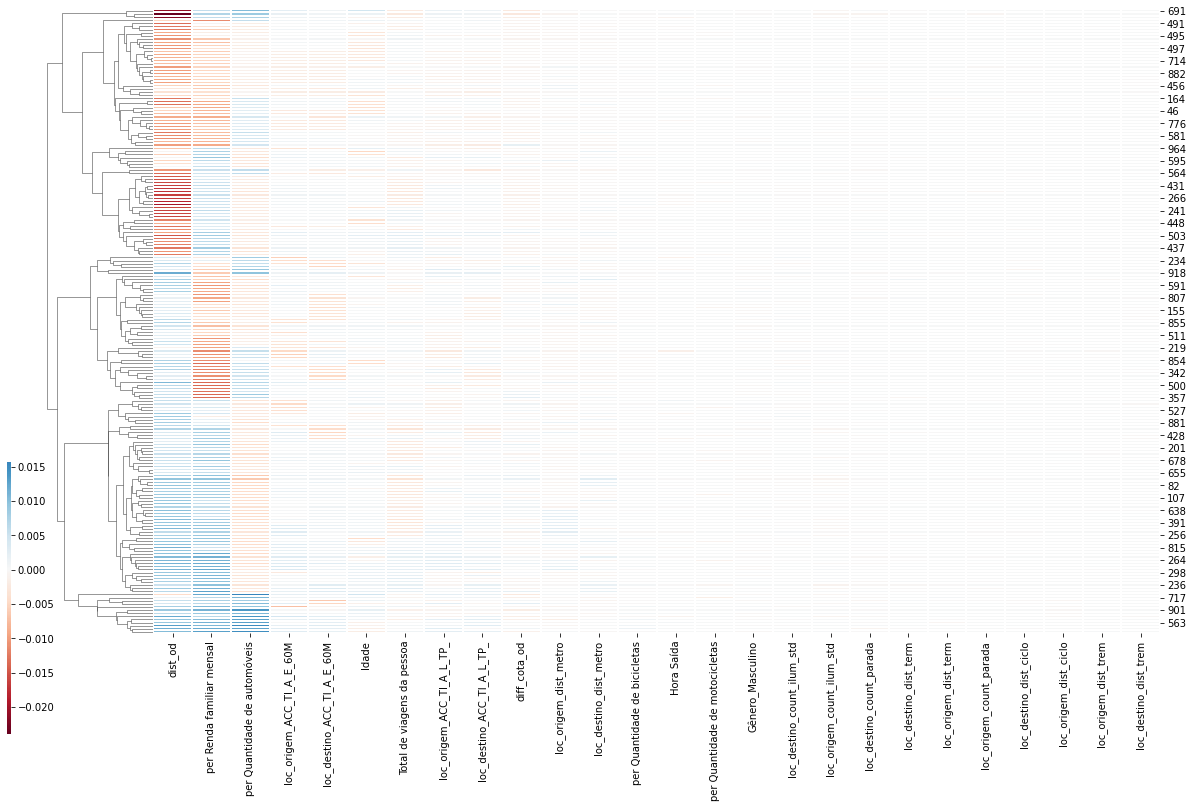

In [79]:
df_shap = pd.DataFrame(shap_values.values[:,:,3], columns=shap_values.feature_names)

f = .9
# Draw the full plot
g = sns.clustermap(df_shap.sample(200), center=0, cmap="RdBu",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(-0.02, 0.08, .003, 0.28),
                   linewidths=.05, figsize=(18*f, 15*f))
g.ax_col_dendrogram.remove()

### SHAP Clustering | Heatmap

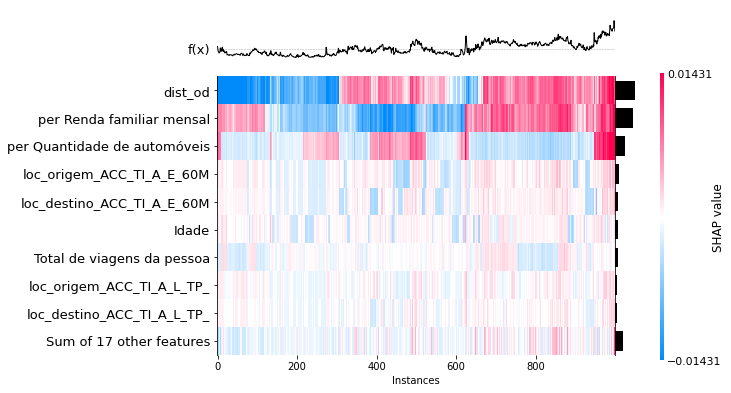

In [52]:
shap.plots.heatmap(shap_values[:,:,3])

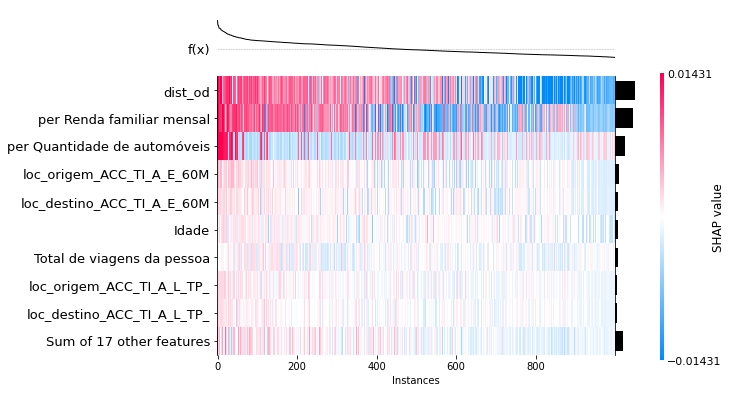

In [54]:
shap.plots.heatmap(shap_values[:,:,3], instance_order=shap_values[:,:,3].sum(1))

### Demographic parity

FixedFormatter should only be used together with FixedLocator


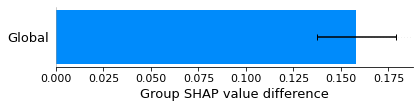

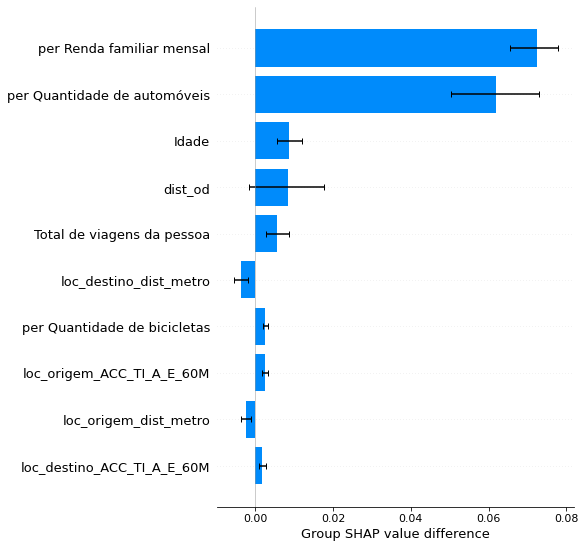

In [64]:
group_A = sample["per Renda familiar mensal"].values >= 3000
shap.group_difference_plot(shap_values[:,:,1].values.sum(1), group_A, ["Global"], max_display=10)
shap.group_difference_plot(shap_values[:,:,1].values, group_A, sample.columns, max_display=10)

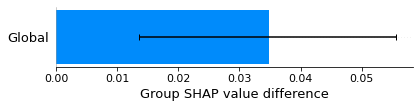

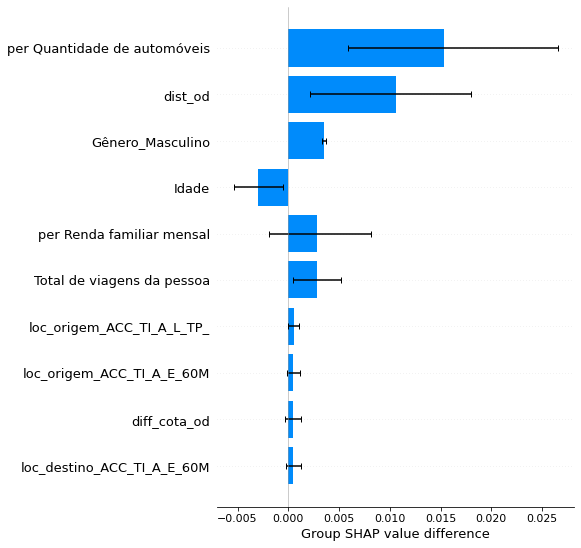

In [66]:
group_A = sample["Gênero_Masculino"].values == 1
shap.group_difference_plot(shap_values[:,:,1].values.sum(1), group_A, ["Global"], max_display=10)
shap.group_difference_plot(shap_values[:,:,1].values, group_A, sample.columns, max_display=10)

### GeoDemographic parity

In [297]:
df_geo.NomeDistri.unique()

array(['Água Rasa', 'Alto de Pinheiros', 'Anhanguera', 'Aricanduva',
       'Artur Alvim', 'Barra Funda', 'Bela Vista', 'Belém', 'Bom Retiro',
       'Brás', 'Brasilândia', 'Butantã', 'Cachoeirinha', 'Cambuci',
       'Campo Belo', 'Campo Grande', 'Campo Limpo', 'Cangaíba',
       'Capão Redondo', 'Carrão', 'Casa Verde', 'Cidade Ademar',
       'Cidade Dutra', 'Cidade Líder', 'Cidade Tiradentes', 'Consolação',
       'Cursino', 'Ermelino Matarazzo', 'Freguesia do Ó', 'Grajaú',
       'Guaianases', 'Iguatemi', 'Ipiranga', 'Itaim Bibi',
       'Itaim Paulista', 'Itaquera', 'Jabaquara', 'Jaçanã', 'Jaguara',
       'Jaguaré', 'Jaraguá', 'Jardim Ângela', 'Jardim Helena',
       'Jardim Paulista', 'Jardim São Luís', 'José Bonifácio', 'Lajeado',
       'Lapa', 'Liberdade', 'Limão', 'Mandaqui', 'Marsilac', 'Moema',
       'Mooca', 'Morumbi', 'Parelheiros', 'Pari', 'Parque do Carmo',
       'Pedreira', 'Penha', 'Perdizes', 'Perus', 'Pinheiros', 'Pirituba',
       'Ponte Rasa', 'Raposo Tavares',

Index(['NumeroDist', 'NomeDistri', 'Area_ha', 'geometry'], dtype='object')


<AxesSubplot:>

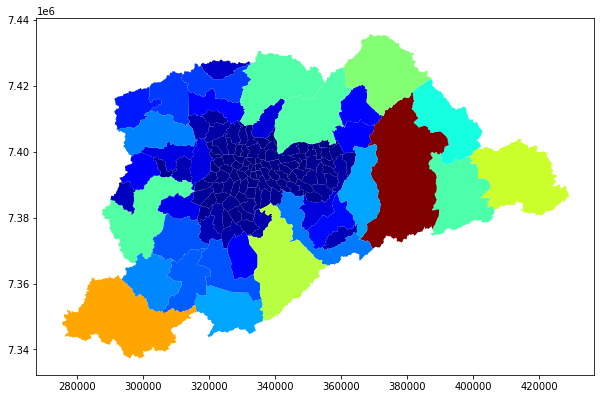

In [67]:
import geopandas as gpd
df_geo = gpd.read_file("/home/yoshraf/projects/mestrado/data/gis/od2017/Distritos_2017_region.shp")
print(df_geo.columns)
df_geo.plot(cmap="jet", column= "Area_ha", figsize=(10,10))

In [80]:
def relevancia(perif, centro, model_idx, map_ref):
    # Georeferênia
    df_sample_geo = gpd.GeoDataFrame(geometry = gpd.points_from_xy(X_train.reset_index()["Coordenada X domicílio"], X_train.reset_index()["Coordenada Y domicílio"]))
    # Seleciona os distristos de interesse
    df_geo_centro = df_geo[df_geo["NomeDistri"].isin(centro)]
    df_geo_perif = df_geo[df_geo["NomeDistri"].isin(perif)]
    # Boolianos se é centro ou periferia do 'X_train'
    bool_centro = gpd.sjoin(df_sample_geo, df_geo_centro, how="left", op='intersects')["index_right"].fillna(0) != 0
    bool_perif = gpd.sjoin(df_sample_geo, df_geo_perif, how="left", op='intersects')["index_right"].fillna(0) != 0
    # Estamos interessados apenas neste dois: Centro e Periferia
    df_final = X_train.reset_index()[bool_centro + bool_perif].set_index(sample.index.names)
    # Calculate shap values for those data
    shap_values = explainer(df_final)
    # Create a GeoDataFrame
    df_sample_geo = gpd.GeoDataFrame(geometry = gpd.points_from_xy(df_final.reset_index()["Coordenada X domicílio"], df_final.reset_index()["Coordenada Y domicílio"]))
    bool_centro_final = gpd.sjoin(df_sample_geo, df_geo_centro, how="left", op='intersects')["index_right"].fillna(0) != 0
    # Plot Group Diff Plot
    for it in model_idx:
        print(map_ref[it])
        print(f"Valor Esperado: {shap_values[:,:,it].base_values[0].round(2)}")
        shap.group_difference_plot(shap_values[:,:,it].values.sum(1), bool_centro_final, ["Global"])
        shap.group_difference_plot(shap_values[:,:,it].values, bool_centro_final, sample.columns, max_display=10)
    

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523



Carro
Valor Esperado: 0.33


FixedFormatter should only be used together with FixedLocator


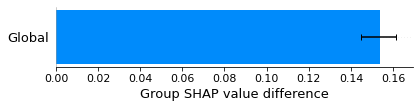

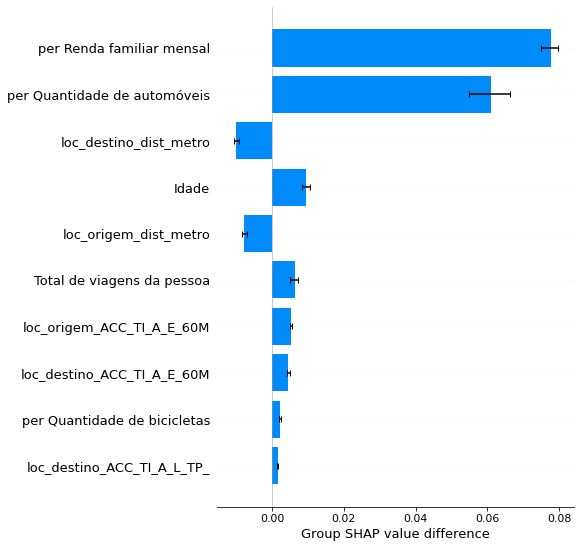

Ônibus
Valor Esperado: 0.16


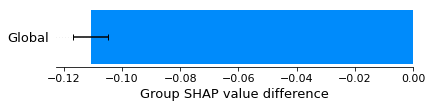

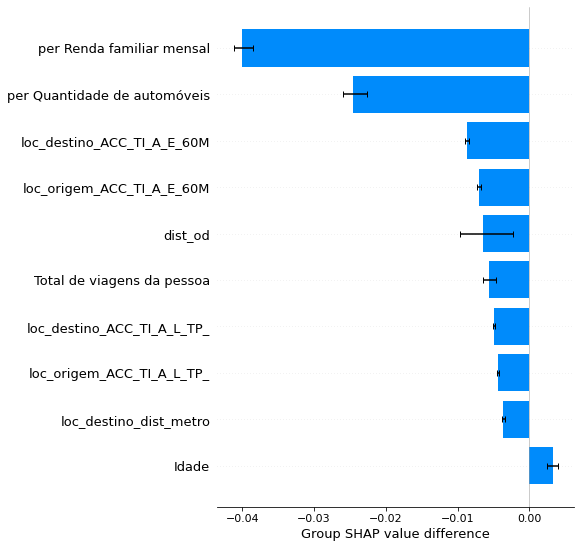

Uber
Valor Esperado: 0.03


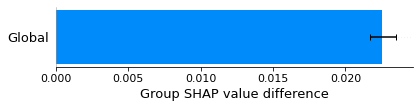

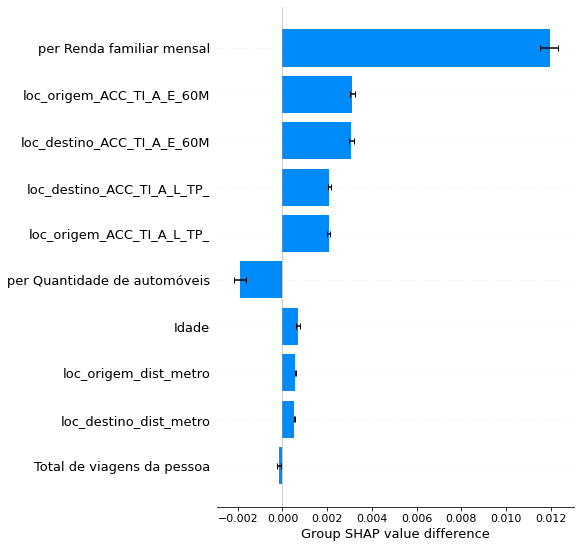

Bike
Valor Esperado: 0.01


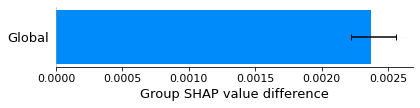

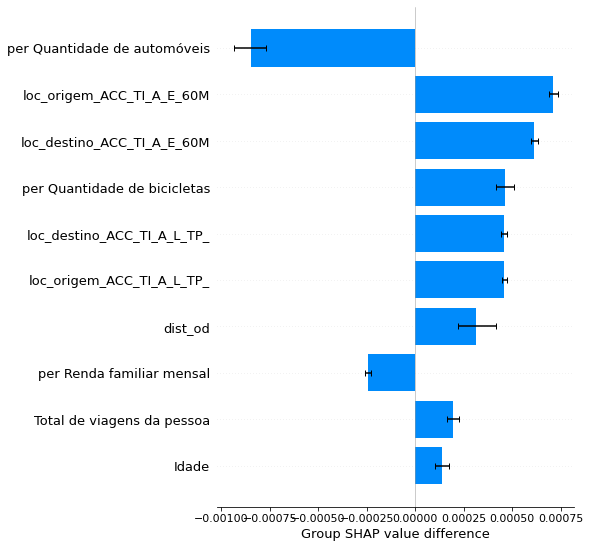

Metro/trem
Valor Esperado: 0.12


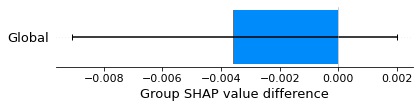

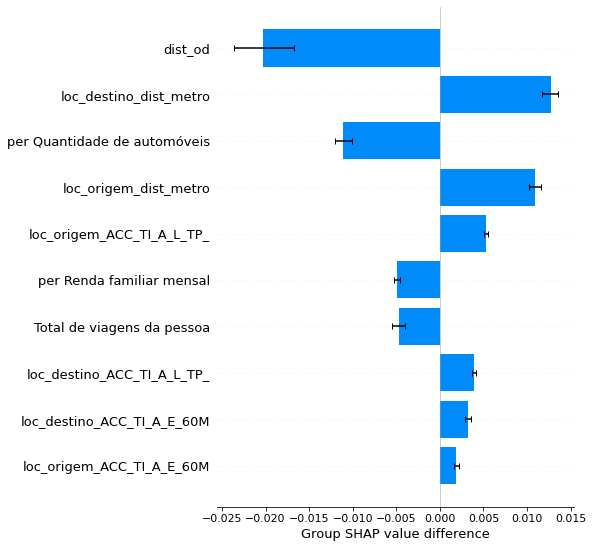

In [81]:
perif = ["Brasilândia", "Grajaú"]
centro = ["Moema", "Bela Vista"]

relevancia(perif, centro, [1,2,3,4,6], map_ref)

Valor da Feature para cada grupo >> Comportamento do Modelo para este modo de Transporte

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

FixedFormatter should only be used together with FixedLocator


Carro
Valor Esperado: 0.33


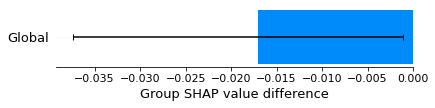

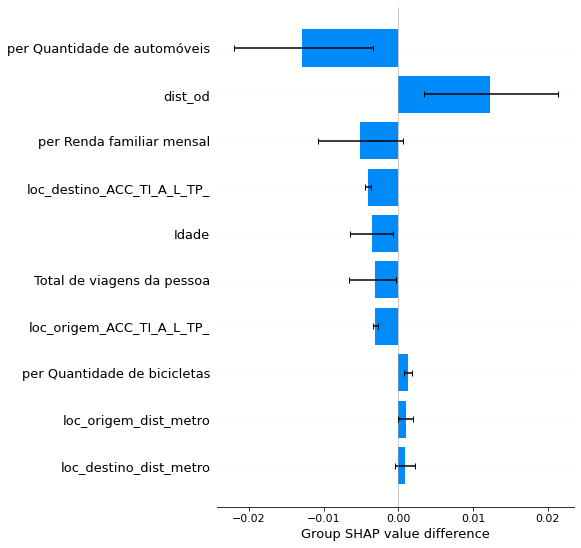

Uber
Valor Esperado: 0.03


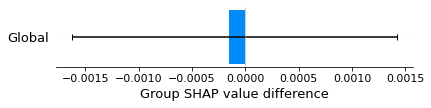

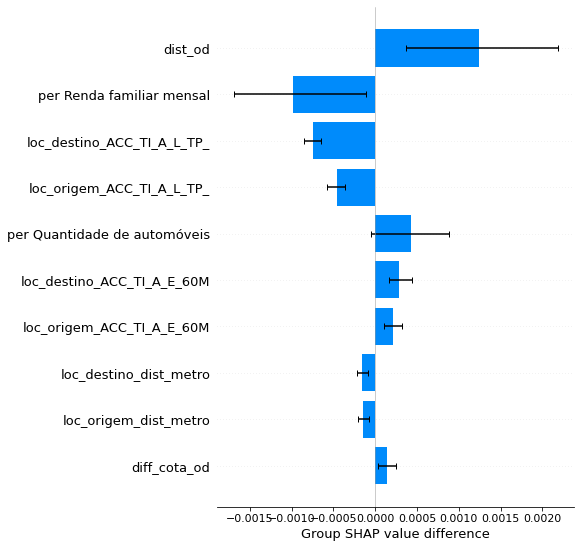

Bike
Valor Esperado: 0.01


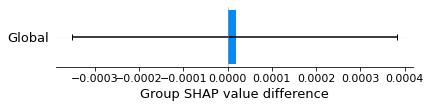

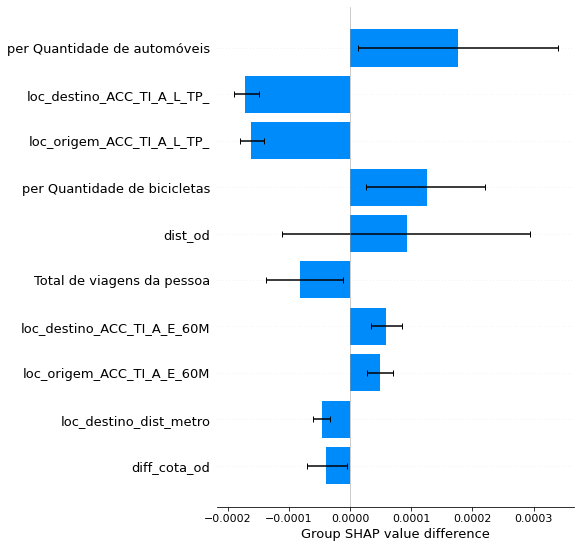

Metro/trem
Valor Esperado: 0.12


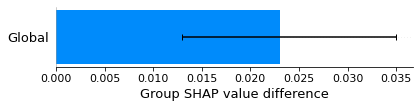

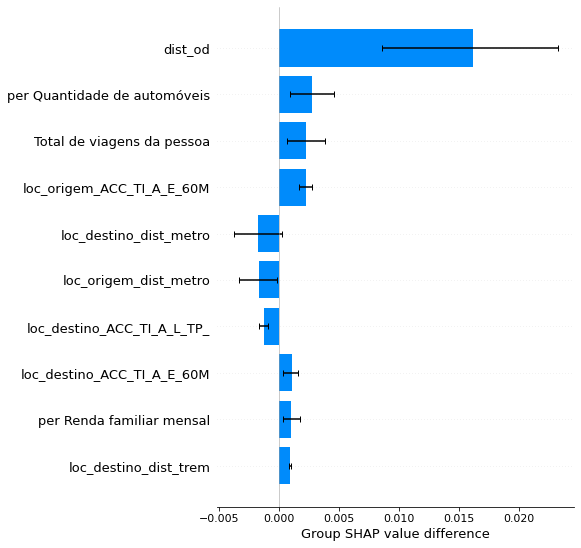

In [82]:
perif = ["Carrão"]
centro = ["Pirituba"]

relevancia(perif, centro, [1,3,4,6], map_ref)

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523



Carro
Valor Esperado: 0.33


FixedFormatter should only be used together with FixedLocator


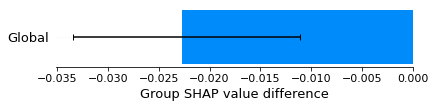

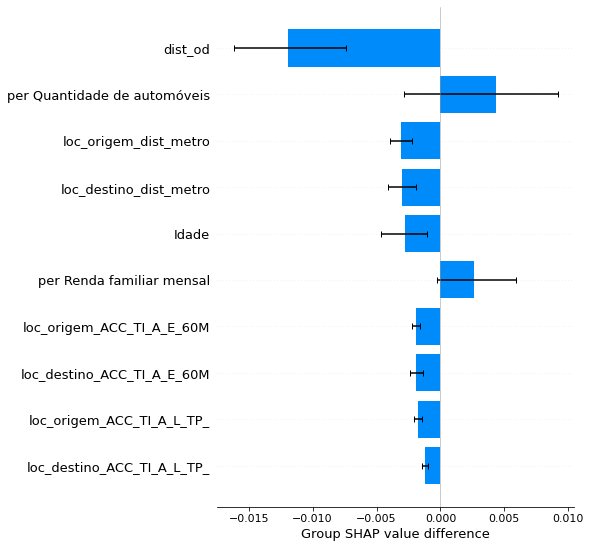

Uber
Valor Esperado: 0.03


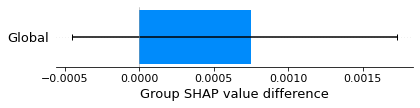

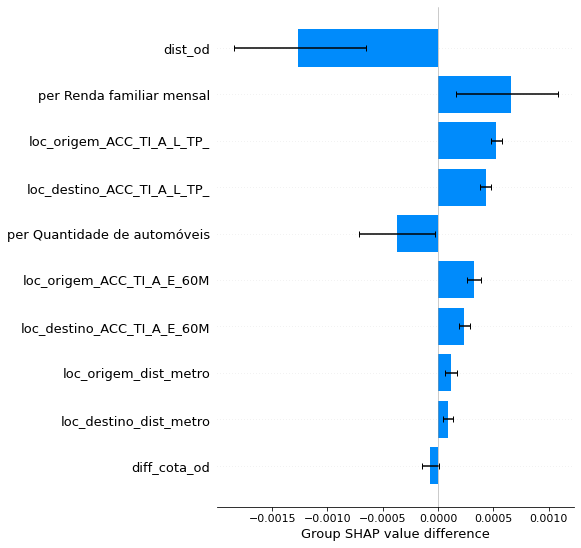

Bike
Valor Esperado: 0.01


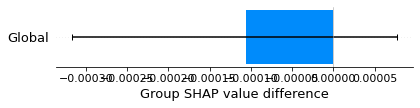

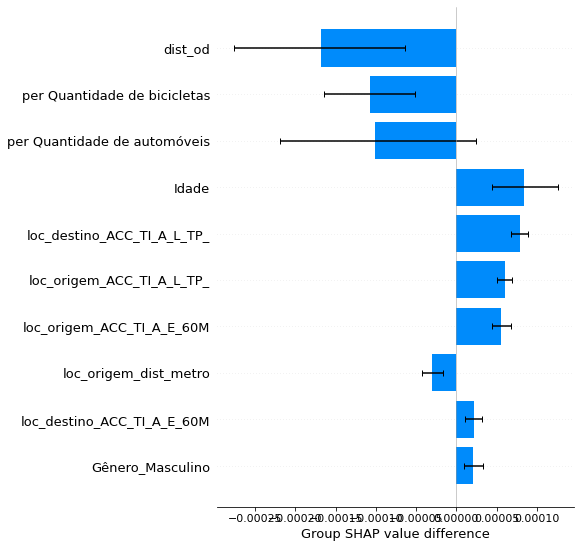

Metro/trem
Valor Esperado: 0.12


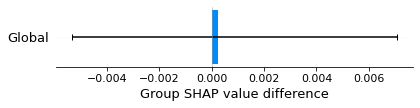

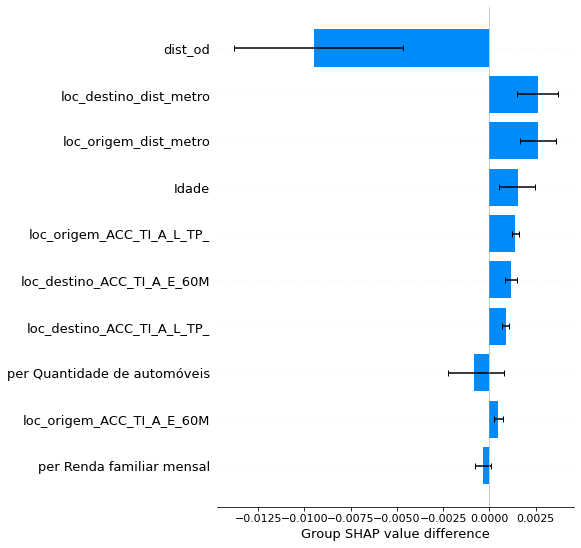

In [83]:
perif = ["Saúde"]
centro = ["Vila Mariana"]

relevancia(perif, centro, [1,3,4,6], map_ref)

### Thank you all!